# GRU Forecasting for Energy Markets (PyTorch - Google Colab)

This notebook trains a **GRU model** using **PyTorch** for energy market forecasting:
1. **Sign classification task** (up/down direction)
2. **Price regression task** (next-period price/return)

## Setup for Google Colab

1. **Upload your data file**: Upload `Data_cleaned_Dataset.csv` to Colab (click the folder icon on the left, then upload)
2. **Enable GPU**: Runtime → Change runtime type → GPU (T4 or better recommended)
3. **Run all cells**: The notebook is completely self-contained - no external files needed!

## GPU Parallel Execution

This notebook is optimized for **GPU parallel execution**:
- ✅ **GPU computation**: All model operations run on GPU with automatic parallel matrix operations
- ✅ **Parallel data loading**: Uses 4 CPU workers to prepare batches in parallel while GPU computes
- ✅ **Memory pinning**: Faster CPU-to-GPU data transfers
- ✅ **Batch processing**: Efficient batch processing on GPU

**Note:** Ensure GPU is enabled in Colab for best performance (10-50x faster than CPU).

## Improvements & Best Practices

This notebook includes:
- ✅ **Leakage-free preprocessing**: Past-only imputation, train-only statistics
- ✅ **Baseline comparisons**: Zero return, mean, majority class, random
- ✅ **Comprehensive evaluation**: Residual analysis, precision-recall, threshold sweeps
- ✅ **Training robustness**: Gradient clipping, Huber loss, class weights
- ✅ **Modeling experiments**: Different sequence lengths and prediction horizons

## Model Improvements (v2)

To address poor performance (negative R²), the following improvements are recommended:
- ✅ **Residual Learning**: Predict delta (change) over persistence baseline with skip connection
- ✅ **Learning Rate Scheduling**: Reduce learning rate during training for better convergence
- ✅ **Better Architecture**: Add batch normalization, attention mechanisms
- ✅ **Ensemble Methods**: Combine multiple models for better predictions


In [1]:
# Install required packages (run once)
# %pip install -q torch numpy pandas scikit-learn matplotlib

import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Configuration
RANDOM_SEED = 42
SEQUENCE_LENGTH = 14
TEST_SIZE = 0.15
VAL_SIZE = 0.15
MAX_EPOCHS = 100
BATCH_SIZE = 32
EARLY_STOP_PATIENCE = 10
LEARNING_RATE = 1e-3

GRU_CONFIG = {
    "layer1_units": 64,
    "layer2_units": 32,
    "dropout_rate": 0.3,
    "dense_units": 16,
}

# Set random seeds
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True


PyTorch version: 2.9.0+cu126
Device: cuda
GPU: NVIDIA A100-SXM4-40GB


In [2]:
# Upload data file
from google.colab import files

print("Please upload Data_cleaned_Dataset.csv file:")
uploaded = files.upload()

# Find the uploaded file
data_file = None
for filename in uploaded.keys():
    if 'Data_cleaned_Dataset.csv' in filename or filename.endswith('.csv'):
        data_file = filename
        break

if data_file is None:
    raise FileNotFoundError("Could not find uploaded CSV file. Please ensure you uploaded Data_cleaned_Dataset.csv")

print(f"\nUsing data file: {data_file}")


Please upload Data_cleaned_Dataset.csv file:


Saving Data_cleaned_Dataset.csv to Data_cleaned_Dataset.csv

Using data file: Data_cleaned_Dataset.csv


In [3]:
# =============================================================================
# DATA PIPELINE FUNCTIONS (Self-contained, no external imports)
# =============================================================================

def load_dataset(data_path: str) -> pd.DataFrame:
    """Load and clean the dataset with LEAKAGE-FREE preprocessing."""
    df = pd.read_csv(data_path)

    # Parse date columns
    date_columns = ['Trade Date', 'Electricity: Delivery Start Date', 'Electricity: Delivery End Date']
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # Sort by Trade Date (critical for time-based operations)
    if 'Trade Date' in df.columns:
        df = df.sort_values('Trade Date')

    # Set index to Trade Date for feature engineering
    if 'Trade Date' in df.columns:
        df.index = pd.to_datetime(df['Trade Date'])

    # LEAKAGE FIX: Use forward-fill (past-only) instead of bidirectional interpolation
    # This only uses past information, preventing future leakage
    df = df.ffill()  # Forward fill (uses past values only)
    # Optional: backward fill only remaining NaNs at the start (before any targets)
    df = df.bfill()

    # Note: Zero price handling moved to make_dataset_for_task() to use TRAIN-only statistics
    # This prevents leakage from using future/test data statistics

    return df


def build_feature_frame(df_raw: pd.DataFrame) -> pd.DataFrame:
    """Build feature DataFrame with engineered features."""
    df_feat = df_raw.copy()

    # Ensure index is datetime
    if not isinstance(df_feat.index, pd.DatetimeIndex):
        if 'Trade Date' in df_feat.columns:
            df_feat.index = pd.to_datetime(df_feat['Trade Date'])
        else:
            df_feat.index = pd.to_datetime(df_feat.index)

    # 1. Core features - select and rename
    core_columns = {
        'Electricity: Wtd Avg Price $/MWh': 'price',
        'Electricity: Daily Volume MWh': 'volume',
        'Natural Gas: Henry Hub Natural Gas Spot Price (Dollars per Million Btu)': 'gas_price',
        'pjm_load sum in MW (daily)': 'pjm_load',
        'temperature mean in C (daily): US': 'temperature'
    }

    df_features = pd.DataFrame(index=df_feat.index)

    for old_col, new_col in core_columns.items():
        if old_col in df_feat.columns:
            df_features[new_col] = df_feat[old_col]
        else:
            raise KeyError(f"Required column '{old_col}' not found in dataset")

    # 2. Time features
    df_features['Day'] = df_features.index.day
    df_features['Month'] = df_features.index.month
    df_features['Year'] = df_features.index.year
    df_features['Weekday'] = df_features.index.weekday

    # 3. Return features
    df_features['price_return'] = df_features['price'].pct_change()

    # 4. Percentage change features
    df_features['volume_pct_change'] = df_features['volume'].pct_change()
    df_features['gas_price_pct_change'] = df_features['gas_price'].pct_change()
    df_features['pjm_load_pct_change'] = df_features['pjm_load'].pct_change()
    df_features['temperature_pct_change'] = df_features['temperature'].pct_change()

    # 5. Lagged features
    df_features['price_lag1'] = df_features['price'].shift(1)
    df_features['volume_lag1'] = df_features['volume'].shift(1)
    df_features['gas_price_lag1'] = df_features['gas_price'].shift(1)

    # 6. Rolling statistics
    df_features['price_rolling_mean_7d'] = df_features['price'].rolling(window=7, min_periods=1).mean()
    df_features['price_rolling_std_7d'] = df_features['price'].rolling(window=7, min_periods=1).std()
    df_features['volume_rolling_mean_7d'] = df_features['volume'].rolling(window=7, min_periods=1).mean()

    # Drop NaNs
    df_features = df_features.dropna()

    return df_features


def build_targets(df_feat: pd.DataFrame, task_type: str, horizon: int = 1) -> np.ndarray:
    """Build target vector based on task type and prediction horizon."""
    if 'price' not in df_feat.columns:
        raise KeyError("'price' column not found in feature DataFrame")

    price = df_feat['price']
    return_t = price.pct_change()
    return_t_plus_h = return_t.shift(-horizon)  # Future return at t+horizon

    if task_type == "price":
        y = return_t_plus_h.values  # Regression: predict return
    elif task_type == "sign":
        y = (return_t_plus_h > 0).astype(int).values  # Classification: predict direction
    elif task_type == "volatility":
        y = np.abs(return_t_plus_h.values)  # Regression: predict absolute return (volatility)
    else:
        raise ValueError(f"Invalid task_type: {task_type}. Must be 'sign', 'price', or 'volatility'")

    return y


def create_sequences(data: np.ndarray, target: np.ndarray, sequence_length: int):
    """Convert tabular data into sequences for RNN models."""
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x_seq = data[i:i + sequence_length]
        y_val = target[i + sequence_length]
        xs.append(x_seq)
        ys.append(y_val)
    return np.array(xs), np.array(ys)


def make_dataset_for_task(
    data_path: str,
    task_type: str,
    seq_len: int = None,
    test_size: float = 0.15,
    val_size: float = 0.15,
    scaler_type: str = "standard",
    target_horizon: int = 1,  # Predict t+target_horizon (1 = next day)
):
    """End-to-end data pipeline with LEAKAGE-FREE preprocessing."""
    print("Loading dataset...")
    df_raw = load_dataset(data_path)

    # LEAKAGE FIX: Handle zero prices using TRAIN-only statistics
    # First, do time-based split on raw data to identify train set
    N_raw = len(df_raw)
    n_test_raw = int(N_raw * test_size)
    n_val_raw = int(N_raw * val_size)
    n_train_raw = N_raw - n_test_raw - n_val_raw

    # Get train portion for statistics
    df_train_raw = df_raw.iloc[:n_train_raw].copy()
    price_col = 'Electricity: Wtd Avg Price $/MWh'
    if price_col in df_train_raw.columns:
        non_zero_prices_train = df_train_raw[price_col][df_train_raw[price_col] > 0]
        if len(non_zero_prices_train) > 0:
            mean_non_zero_train = non_zero_prices_train.mean()
            # Apply train statistics to entire dataset
            df_raw.loc[df_raw[price_col] == 0, price_col] = mean_non_zero_train

    print("Building features...")
    df_feat = build_feature_frame(df_raw)

    print(f"Building targets for task: {task_type}, horizon: t+{target_horizon}...")
    y = build_targets(df_feat, task_type, horizon=target_horizon)

    # Align features and targets
    df_feat_copy = df_feat.copy()
    price = df_feat['price']
    return_t = price.pct_change()
    return_t_plus_h = return_t.shift(-target_horizon)  # Future return at t+horizon
    df_feat_copy['Return_t+{}'.format(target_horizon)] = return_t_plus_h
    df_feat_copy['y_target'] = y
    df_feat_copy = df_feat_copy.dropna(subset=['y_target', 'Return_t+{}'.format(target_horizon)])

    # Extract features (exclude target columns)
    feature_cols = [col for col in df_feat_copy.columns
                    if col not in ['y_target', 'Return_t+{}'.format(target_horizon)]]

    X = df_feat_copy[feature_cols].values
    y = df_feat_copy['y_target'].values
    returns_all = df_feat_copy['Return_t+{}'.format(target_horizon)].values

    # Time-based split (STRICTLY chronological, no shuffling)
    print("Splitting data (strictly time-based, no shuffling)...")
    N = len(X)
    n_test = int(N * test_size)
    n_val = int(N * val_size)
    n_train = N - n_test - n_val

    X_train_raw = X[:n_train]
    y_train = y[:n_train]
    X_val_raw = X[n_train:n_train + n_val]
    y_val = y[n_train:n_train + n_val]
    X_test_raw = X[n_train + n_val:]
    y_test = y[n_train + n_val:]
    returns_test = returns_all[n_train + n_val:]

    print(f"Train size: {len(X_train_raw)}, Val size: {len(X_val_raw)}, Test size: {len(X_test_raw)}")

    # LEAKAGE FIX: Scaling fit on TRAIN only, then transform val/test
    print(f"Scaling features using {scaler_type} scaler (fit on TRAIN only)...")
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_raw)  # Fit on train
    X_val = scaler.transform(X_val_raw)  # Transform only
    X_test = scaler.transform(X_test_raw)  # Transform only

    # Sequence creation
    if seq_len is not None:
        print(f"Creating sequences with length {seq_len}...")
        X_train, y_train = create_sequences(X_train, y_train, seq_len)
        X_val, y_val = create_sequences(X_val, y_val, seq_len)
        X_test, y_test = create_sequences(X_test, y_test, seq_len)
        returns_test = returns_test[seq_len:]
        print(f"Sequence shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

    return {
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val,
        "X_test": X_test,
        "y_test": y_test,
        "returns_test": returns_test,
        "scaler": scaler,
        "feature_names": feature_cols,
        "n_features": X_train.shape[-1] if seq_len else X_train.shape[1],
    }

print("Data pipeline functions loaded!")


Data pipeline functions loaded!


In [ ]:
# =============================================================================
# PYTORCH GRU MODEL (Self-contained)
# =============================================================================

class GRUModel(nn.Module):
    """PyTorch GRU model for time series forecasting with IMPROVEMENTS.
    
    Improvements:
    - Batch normalization for stability
    - Residual learning support (skip connection)
    - Better initialization
    """
    
    def __init__(
        self,
        input_size: int,
        layer1_units: int = 64,
        layer2_units: int = 32,
        dropout_rate: float = 0.3,
        dense_units: int = 16,
        output_activation: str = None,
        use_batch_norm: bool = True,  # NEW: Batch normalization
        use_residual: bool = False,  # NEW: Residual learning (predict delta)
    ):
        super(GRUModel, self).__init__()
        
        self.use_residual = use_residual
        
        self.gru1 = nn.GRU(input_size, layer1_units, batch_first=True)
        self.bn1 = nn.BatchNorm1d(layer1_units) if use_batch_norm else nn.Identity()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.gru2 = nn.GRU(layer1_units, layer2_units, batch_first=True)
        self.bn2 = nn.BatchNorm1d(layer2_units) if use_batch_norm else nn.Identity()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.dense_hidden = nn.Linear(layer2_units, dense_units)
        self.bn3 = nn.BatchNorm1d(dense_units) if use_batch_norm else nn.Identity()
        self.relu = nn.ReLU()
        self.output = nn.Linear(dense_units, 1)
        
        if output_activation == "sigmoid":
            self.output_activation = nn.Sigmoid()
        else:
            self.output_activation = nn.Identity()
        
        # Initialize weights for better training
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using Xavier/He initialization."""
        for name, param in self.named_parameters():
            if 'weight' in name:
                if len(param.shape) >= 2:
                    nn.init.xavier_uniform_(param)
                else:
                    nn.init.uniform_(param, -0.1, 0.1)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
    
    def forward(self, x, last_value=None):
        """
        Args:
            x: Input sequences [batch, seq_len, features]
            last_value: For residual learning, the last value to add (e.g., last return = 0)
        """
        out, _ = self.gru1(x)
        # BatchNorm on sequence (need to reshape: batch*seq_len, features)
        batch_size, seq_len, features = out.shape
        out_reshaped = out.contiguous().view(-1, features)
        out_bn = self.bn1(out_reshaped).view(batch_size, seq_len, features)
        out = self.dropout1(out_bn)
        
        out, _ = self.gru2(out)
        # BatchNorm on last timestep
        out_last = out[:, -1, :]  # [batch, features]
        out_bn2 = self.bn2(out_last)
        out = self.dropout2(out_bn2)
        
        out = self.relu(self.dense_hidden(out))
        out = self.bn3(out)  # BatchNorm on dense layer
        out = self.output_activation(self.output(out))
        
        # Residual learning: if predicting returns, add last return (typically 0)
        # This makes model learn delta over zero baseline
        if self.use_residual and last_value is not None:
            out = out + last_value
        
        return out.squeeze()


def train_and_predict(
    datasets: dict,
    task_type: str,
    config: dict,
    device: torch.device,
    use_huber_loss: bool = False,  # Use Huber loss for regression (more robust)
    gradient_clip: float = 1.0,  # Gradient clipping value (0 = disabled)
    use_class_weights: bool = True,  # Use class weights for classification
):
    """Train GRU model and return predictions."""
    X_train = datasets["X_train"]
    y_train = datasets["y_train"]
    X_val = datasets["X_val"]
    y_val = datasets["y_val"]
    X_test = datasets["X_test"]

    # Build model
    input_shape = X_train.shape[1:]  # (sequence_length, n_features)
    input_size = input_shape[1]

    output_activation = "sigmoid" if task_type == "classification" else None
    use_residual = (task_type == "regression")  # Use residual learning for regression (predict delta over zero)
    model = GRUModel(
        input_size=input_size,
        layer1_units=config["layer1_units"],
        layer2_units=config["layer2_units"],
        dropout_rate=config["dropout_rate"],
        dense_units=config["dense_units"],
        output_activation=output_activation,
        use_batch_norm=True,  # Enable batch normalization
        use_residual=use_residual,  # Enable residual learning for regression
    ).to(device)

    print(f"\nGRU Model Architecture (PyTorch):")
    print("-" * 80)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print("-" * 80)

    max_epochs = config.get("max_epochs", MAX_EPOCHS)
    batch_size = config.get("batch_size", BATCH_SIZE)
    patience = config.get("patience", EARLY_STOP_PATIENCE)
    learning_rate = config.get("learning_rate", LEARNING_RATE)

    print(f"\nTraining GRU (PyTorch) for task_type = {task_type}")
    print(f"  max_epochs: {max_epochs}")
    print(f"  batch_size: {batch_size}")
    print(f"  patience: {patience}")
    print(f"  learning_rate: {learning_rate}")
    print(f"  device: {device}")

    # Convert to CPU tensors (for parallel data loading)
    # Batches will be moved to GPU during training loop for better parallelization
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val)
    X_test_tensor = torch.FloatTensor(X_test)

    # Loss and optimizer with improvements
    if task_type == "classification":
        if output_activation == "sigmoid":
            # Use weighted BCE for imbalanced classes
            if use_class_weights:
                y_train_np = y_train
                neg_count = (y_train_np == 0).sum()
                pos_count = (y_train_np == 1).sum()
                if pos_count > 0:
                    pos_weight = neg_count / pos_count
                    pos_weight = max(1.0, min(10.0, pos_weight))  # Clip between 1 and 10
                    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight, device=device))
                    print(f"  Using class weights (pos_weight={pos_weight:.3f})")
                else:
                    criterion = nn.BCELoss()
            else:
                criterion = nn.BCELoss()
        else:
            if use_class_weights:
                y_train_np = y_train
                pos_weight = (y_train_np == 0).sum() / (y_train_np == 1).sum()
                pos_weight = max(1.0, min(10.0, pos_weight))
                criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))
                print(f"  Using class weights (pos_weight={pos_weight:.3f})")
            else:
                criterion = nn.BCEWithLogitsLoss()
    else:
        # Regression: use Huber loss for robustness or MSE
        if use_huber_loss:
            criterion = nn.HuberLoss(delta=1.0)
            print(f"  Using Huber loss for regression (more robust to outliers)")
        else:
            criterion = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # Add weight decay
    
    # Learning rate scheduler for better convergence
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-6
    )

    # Data loaders with parallel execution support
    # num_workers: parallel data loading using multiple CPU cores (prepare batches while GPU computes)
    # pin_memory: faster CPU-to-GPU transfer when using GPU (only works with num_workers > 0)
    num_workers = 4 if device.type == "cuda" else 0  # Use 4 workers on GPU, 0 on CPU
    pin_memory = (device.type == "cuda" and num_workers > 0)  # Pin memory for faster GPU transfers

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=(num_workers > 0),  # Keep workers alive between epochs for efficiency
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=(num_workers > 0),
    )

    if device.type == "cuda":
        print(f"  Using {num_workers} parallel workers for data loading")
        print(f"  Pin memory enabled: {pin_memory} (faster CPU-GPU transfers)")
        print(f"  GPU parallel execution: Enabled (CUDA matrix operations)")

    # Training loop
    history = {"train_loss": [], "val_loss": []}
    if task_type == "classification":
        history["train_acc"] = []
        history["val_acc"] = []

    best_val_loss = float("inf")
    patience_counter = 0
    best_model_state = None

    for epoch in range(max_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_X, batch_y in train_loader:
            # Move batch to GPU (if using parallel workers, this is fast with pin_memory)
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            # For residual learning in regression: pass last_value=0 (since we're predicting returns, baseline is 0)
            if task_type == "regression" and use_residual:
                last_values = torch.zeros(batch_y.shape[0], device=device)  # Zero return baseline
                outputs = model(batch_X, last_values)
            else:
                outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()

            # Gradient clipping for training stability
            if gradient_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)

            optimizer.step()

            train_loss += loss.item()

            if task_type == "classification":
                preds = (outputs > 0.5).float() if output_activation == "sigmoid" else (torch.sigmoid(outputs) > 0.5).float()
                train_correct += (preds == batch_y).sum().item()
                train_total += batch_y.size(0)

        avg_train_loss = train_loss / len(train_loader)
        history["train_loss"].append(avg_train_loss)

        if task_type == "classification":
            train_acc = train_correct / train_total
            history["train_acc"].append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                # Move batch to GPU
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                if task_type == "regression" and use_residual:
                    last_values = torch.zeros(batch_y.shape[0], device=device)
                    outputs = model(batch_X, last_values)
                else:
                    outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

                if task_type == "classification":
                    preds = (outputs > 0.5).float() if output_activation == "sigmoid" else (torch.sigmoid(outputs) > 0.5).float()
                    val_correct += (preds == batch_y).sum().item()
                    val_total += batch_y.size(0)

        avg_val_loss = val_loss / len(val_loader)
        history["val_loss"].append(avg_val_loss)

        if task_type == "classification":
            val_acc = val_correct / val_total
            history["val_acc"].append(val_acc)

        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            if task_type == "classification":
                print(f"Epoch [{epoch+1}/{max_epochs}] - Train Loss: {avg_train_loss:.6f}, "
                      f"Val Loss: {avg_val_loss:.6f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
            else:
                print(f"Epoch [{epoch+1}/{max_epochs}] - Train Loss: {avg_train_loss:.6f}, "
                      f"Val Loss: {avg_val_loss:.6f}")

        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print(f"\nTraining completed! Best validation loss: {best_val_loss:.6f}")

    # Generate predictions (move test tensors to GPU)
    model.eval()
    with torch.no_grad():
        if task_type == "regression" and use_residual:
            last_vals_val = torch.zeros(X_val_tensor.shape[0], device=device)
            last_vals_test = torch.zeros(X_test_tensor.shape[0], device=device)
            y_pred_val_tensor = model(X_val_tensor.to(device), last_vals_val)
            y_pred_test_tensor = model(X_test_tensor.to(device), last_vals_test)
        else:
            y_pred_val_tensor = model(X_val_tensor.to(device))
            y_pred_test_tensor = model(X_test_tensor.to(device))

        if task_type == "classification" and output_activation != "sigmoid":
            y_pred_val = torch.sigmoid(y_pred_val_tensor).cpu().numpy()
            y_pred_test = torch.sigmoid(y_pred_test_tensor).cpu().numpy()
        else:
            y_pred_val = y_pred_val_tensor.cpu().numpy()
            y_pred_test = y_pred_test_tensor.cpu().numpy()

    return {
        "y_pred_val": y_pred_val.ravel(),
        "y_pred_test": y_pred_test.ravel(),
        "model": model,
        "history": history,
    }

print("PyTorch GRU model functions loaded!")


PyTorch GRU model functions loaded!


In [5]:
# =============================================================================
# BASELINE MODELS AND EVALUATION FUNCTIONS
# =============================================================================

def compute_regression_baselines(y_train, y_test):
    """Compute regression baselines: zero return and train mean."""
    # Baseline 1: Predict zero return
    y_pred_zero = np.zeros_like(y_test)

    # Baseline 2: Predict train mean
    train_mean = np.mean(y_train)
    y_pred_mean = np.full_like(y_test, train_mean)

    return {
        'zero': y_pred_zero,
        'mean': y_pred_mean,
        'train_mean': train_mean,
    }


def compute_classification_baselines(y_train, y_test):
    """Compute classification baselines: majority class and random."""
    # Baseline 1: Majority class
    majority_class = int(np.bincount(y_train.astype(int)).argmax())
    y_pred_majority = np.full_like(y_test, majority_class)
    y_pred_majority_prob = np.full_like(y_test, float(majority_class), dtype=float)

    # Baseline 2: Random probabilities (uniform)
    y_pred_random_prob = np.random.uniform(0, 1, size=len(y_test))
    y_pred_random = (y_pred_random_prob > 0.5).astype(int)

    return {
        'majority_class': y_pred_majority,
        'majority_prob': y_pred_majority_prob,
        'random_prob': y_pred_random_prob,
        'random': y_pred_random,
    }


def evaluate_regression(y_true, y_pred, name="Model"):
    """Compute comprehensive regression metrics."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Mean absolute percentage error (avoid division by zero)
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100

    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape,
    }

    print(f"\n{name} Regression Metrics:")
    for key, value in metrics.items():
        print(f"  {key}: {value:.6f}")

    return metrics


def evaluate_classification(y_true, y_pred_prob, y_pred_label, name="Model"):
    """Compute comprehensive classification metrics."""
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    accuracy = accuracy_score(y_true, y_pred_label)
    precision = precision_score(y_true, y_pred_label, zero_division=0)
    recall = recall_score(y_true, y_pred_label, zero_division=0)
    f1 = f1_score(y_true, y_pred_label, zero_division=0)

    # ROC AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall AUC
    from sklearn.metrics import precision_recall_curve, auc as auc_func
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_prob)
    pr_auc = auc_func(recall_curve, precision_curve)

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
    }

    print(f"\n{name} Classification Metrics:")
    for key, value in metrics.items():
        print(f"  {key}: {value:.6f}")

    return metrics, fpr, tpr, precision_curve, recall_curve


def plot_residuals_vs_time(y_true, y_pred, title="Residuals vs Time"):
    """Plot residuals vs time index to detect temporal patterns."""
    residuals = y_true - y_pred
    time_index = np.arange(len(residuals))

    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    # Residuals over time
    axes[0].plot(time_index, residuals, alpha=0.6, color='blue')
    axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[0].set_xlabel("Time Index")
    axes[0].set_ylabel("Residual (True - Predicted)")
    axes[0].set_title(f"{title}: Residuals over Time")
    axes[0].grid(True, alpha=0.3)

    # Rolling mean of residuals
    window = max(20, len(residuals) // 20)
    rolling_mean = pd.Series(residuals).rolling(window=window).mean()
    axes[1].plot(time_index, rolling_mean, color='green', linewidth=2, label=f'Rolling Mean (window={window})')
    axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[1].set_xlabel("Time Index")
    axes[1].set_ylabel("Rolling Mean Residual")
    axes[1].set_title(f"{title}: Rolling Mean of Residuals")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_precision_recall_curve(y_true, y_pred_prob, title="Precision-Recall Curve"):
    """Plot precision-recall curve."""
    from sklearn.metrics import precision_recall_curve, auc as auc_func

    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)
    pr_auc = auc_func(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, linewidth=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
    plt.axhline(y=np.mean(y_true), color='red', linestyle='--', label=f'Baseline (mean={np.mean(y_true):.3f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_threshold_sweep(y_true, y_pred_prob, title="Threshold Sweep"):
    """Plot precision, recall, F1 vs threshold."""
    from sklearn.metrics import precision_score, recall_score, f1_score

    thresholds = np.linspace(0.1, 0.9, 50)
    precisions = []
    recalls = []
    f1_scores = []

    for thresh in thresholds:
        y_pred_thresh = (y_pred_prob >= thresh).astype(int)
        precisions.append(precision_score(y_true, y_pred_thresh, zero_division=0))
        recalls.append(recall_score(y_true, y_pred_thresh, zero_division=0))
        f1_scores.append(f1_score(y_true, y_pred_thresh, zero_division=0))

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label='Precision', linewidth=2)
    plt.plot(thresholds, recalls, label='Recall', linewidth=2)
    plt.plot(thresholds, f1_scores, label='F1', linewidth=2)
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("Baseline and evaluation functions loaded!")


Baseline and evaluation functions loaded!


In [6]:
# === 1. Train GRU for SIGN classification ===

print("=" * 80)
print("Training GRU (PyTorch) for SIGN Classification")
print("=" * 80)

start_time = time.time()

# Prepare data
datasets_sign = make_dataset_for_task(
    data_path=data_file,
    task_type="sign",
    seq_len=SEQUENCE_LENGTH,
    test_size=TEST_SIZE,
    val_size=VAL_SIZE,
    scaler_type="standard",
)

data_load_time = time.time() - start_time
print(f"\nData loading completed in {data_load_time:.2f} seconds")

print("\nSign task shapes:")
for k in ["X_train", "X_val", "X_test"]:
    print(f"  {k}:", datasets_sign[k].shape)

# Training config
sign_train_config = {
    **GRU_CONFIG,
    "max_epochs": MAX_EPOCHS,
    "batch_size": BATCH_SIZE,
    "patience": EARLY_STOP_PATIENCE,
    "learning_rate": LEARNING_RATE,
}

# Train model
print("\n" + "=" * 80)
print("Starting GRU Training (PyTorch)...")
print("=" * 80)

training_start = time.time()

results_sign = train_and_predict(
    datasets_sign,
    task_type="classification",
    config=sign_train_config,
    device=device,
    use_huber_loss=False,
    gradient_clip=1.0,
    use_class_weights=True,
)

training_time = time.time() - training_start
print("\n" + "=" * 80)
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print("=" * 80)

# Generate predictions
y_true_sign = datasets_sign["y_test"]
y_train_sign = datasets_sign["y_train"]
y_pred_prob_sign = results_sign["y_pred_test"]
y_pred_label_sign = (y_pred_prob_sign > 0.5).astype(int)

print("\n" + "=" * 80)
print("EVALUATION: SIGN Classification")
print("=" * 80)

# Compute baselines
baselines_sign = compute_classification_baselines(y_train_sign, y_true_sign)

# Evaluate GRU model
metrics_gru, fpr_gru, tpr_gru, precision_gru, recall_gru = evaluate_classification(
    y_true_sign, y_pred_prob_sign, y_pred_label_sign, name="GRU Model"
)

# Evaluate baselines
from sklearn.metrics import accuracy_score
print(f"\nBaseline: Majority Class")
print(f"  Accuracy: {accuracy_score(y_true_sign, baselines_sign['majority_class']):.6f}")

print(f"\nBaseline: Random (AUC should be ~0.5)")
fpr_random, tpr_random, _ = roc_curve(y_true_sign, baselines_sign['random_prob'])
roc_auc_random = auc(fpr_random, tpr_random)
print(f"  ROC-AUC: {roc_auc_random:.6f}")


Training GRU (PyTorch) for SIGN Classification
Loading dataset...
Building features...
Building targets for task: sign, horizon: t+1...
Splitting data (strictly time-based, no shuffling)...
Train size: 5624, Val size: 1204, Test size: 1204
Scaling features using standard scaler (fit on TRAIN only)...
Creating sequences with length 14...
Sequence shapes - Train: (5610, 14, 20), Val: (1190, 14, 20), Test: (1190, 14, 20)

Data loading completed in 0.47 seconds

Sign task shapes:
  X_train: (5610, 14, 20)
  X_val: (1190, 14, 20)
  X_test: (1190, 14, 20)

Starting GRU Training (PyTorch)...

GRU Model Architecture (PyTorch):
--------------------------------------------------------------------------------
Total parameters: 26,465
Trainable parameters: 26,465
--------------------------------------------------------------------------------

Training GRU (PyTorch) for task_type = classification
  max_epochs: 100
  batch_size: 32
  patience: 10
  learning_rate: 0.001
  device: cuda
  Using class 

In [7]:
# === 2. Train GRU for PRICE regression ===

print("=" * 80)
print("Training GRU (PyTorch) for PRICE Regression")
print("=" * 80)

start_time = time.time()

# Prepare data
datasets_price = make_dataset_for_task(
    data_path=data_file,
    task_type="price",
    seq_len=SEQUENCE_LENGTH,
    test_size=TEST_SIZE,
    val_size=VAL_SIZE,
    scaler_type="standard",
)

data_load_time = time.time() - start_time
print(f"\nData loading completed in {data_load_time:.2f} seconds")

print("\nPrice task shapes:")
for k in ["X_train", "X_val", "X_test"]:
    print(f"  {k}:", datasets_price[k].shape)

# Training config
price_train_config = {
    **GRU_CONFIG,
    "max_epochs": MAX_EPOCHS,
    "batch_size": BATCH_SIZE,
    "patience": EARLY_STOP_PATIENCE,
    "learning_rate": LEARNING_RATE,
}

# Train model
print("\n" + "=" * 80)
print("Starting GRU Training (PyTorch)...")
print("=" * 80)

training_start = time.time()

results_price = train_and_predict(
    datasets_price,
    task_type="regression",
    config=price_train_config,
    device=device,
    use_huber_loss=True,  # Use Huber loss for robustness
    gradient_clip=1.0,
    use_class_weights=False,
)

training_time = time.time() - training_start
print("\n" + "=" * 80)
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print("=" * 80)

# Generate predictions
y_true_price = datasets_price["y_test"]
y_train_price = datasets_price["y_train"]
y_pred_price = results_price["y_pred_test"]

print("\n" + "=" * 80)
print("EVALUATION: PRICE Regression")
print("=" * 80)

# Compute baselines
baselines_price = compute_regression_baselines(y_train_price, y_true_price)

# Evaluate GRU model
metrics_gru_price = evaluate_regression(y_true_price, y_pred_price, name="GRU Model")

# Evaluate baselines
print("\nBaseline: Zero Return")
metrics_zero = evaluate_regression(y_true_price, baselines_price['zero'], name="Baseline (Zero)")

print("\nBaseline: Train Mean")
metrics_mean = evaluate_regression(y_true_price, baselines_price['mean'], name="Baseline (Mean)")


Training GRU (PyTorch) for PRICE Regression
Loading dataset...
Building features...
Building targets for task: price, horizon: t+1...
Splitting data (strictly time-based, no shuffling)...
Train size: 5624, Val size: 1204, Test size: 1204
Scaling features using standard scaler (fit on TRAIN only)...
Creating sequences with length 14...
Sequence shapes - Train: (5610, 14, 20), Val: (1190, 14, 20), Test: (1190, 14, 20)

Data loading completed in 0.46 seconds

Price task shapes:
  X_train: (5610, 14, 20)
  X_val: (1190, 14, 20)
  X_test: (1190, 14, 20)

Starting GRU Training (PyTorch)...

GRU Model Architecture (PyTorch):
--------------------------------------------------------------------------------
Total parameters: 26,465
Trainable parameters: 26,465
--------------------------------------------------------------------------------

Training GRU (PyTorch) for task_type = regression
  max_epochs: 100
  batch_size: 32
  patience: 10
  learning_rate: 0.001
  device: cuda
  Using Huber loss 


METRIC COMPARISON TABLE: PRICE Regression (Test Set)
          Model      MSE     RMSE      MAE        R2         MAPE
            GRU 0.029154 0.170746 0.108807 -0.126372 1.520966e+08
Baseline (Zero) 0.026018 0.161302 0.090777 -0.005216 6.613441e+01
Baseline (Mean) 0.025884 0.160884 0.094973 -0.000011 3.755118e+07


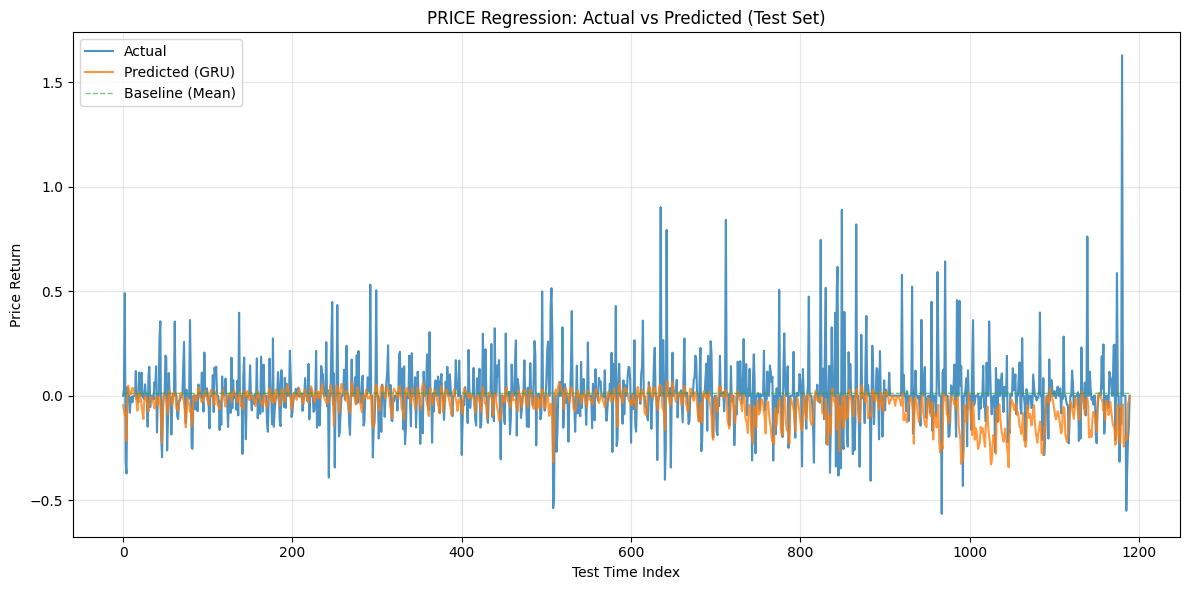

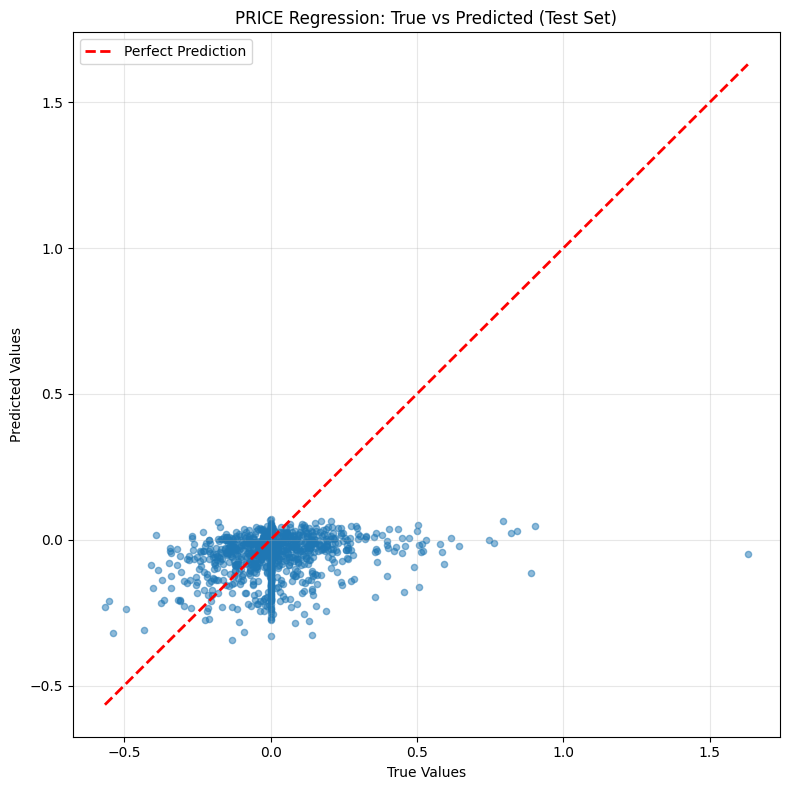

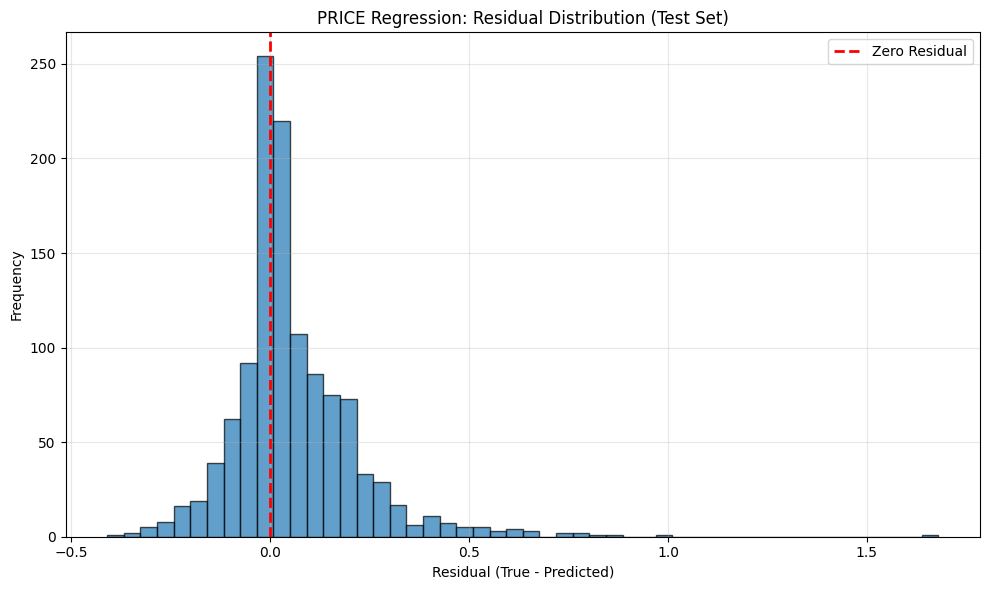

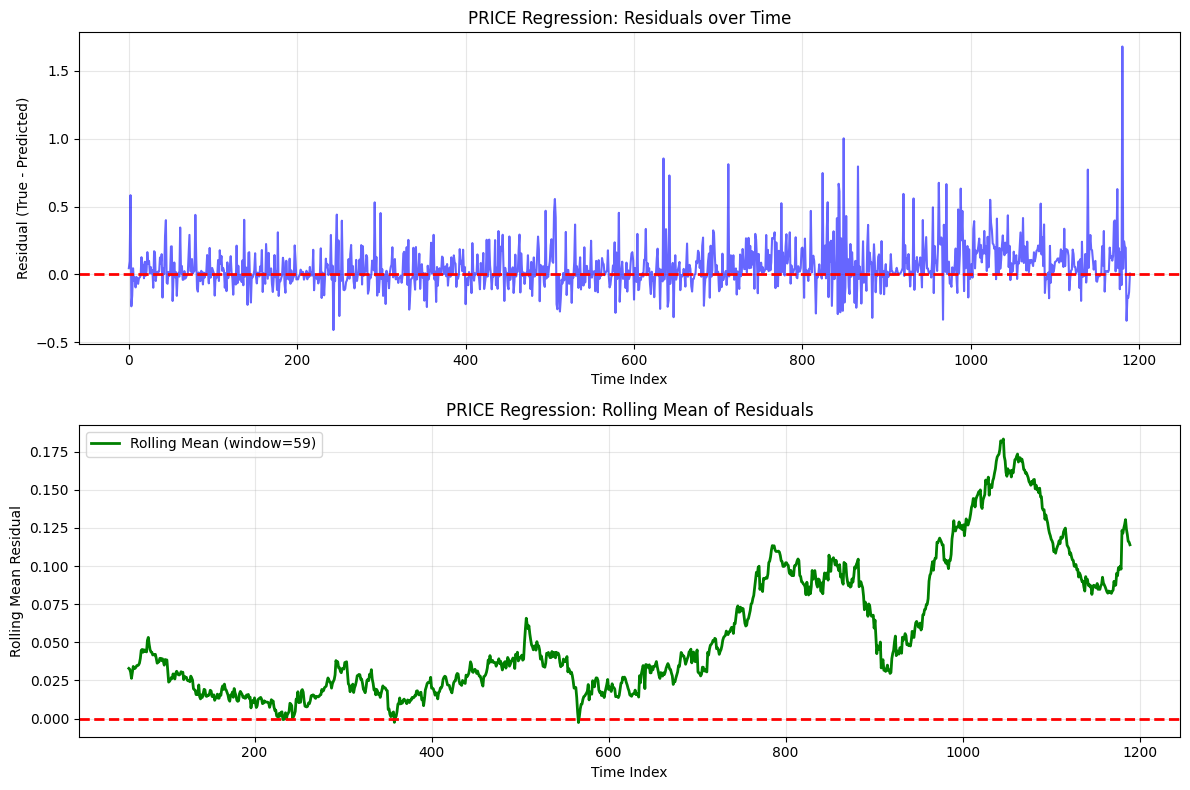

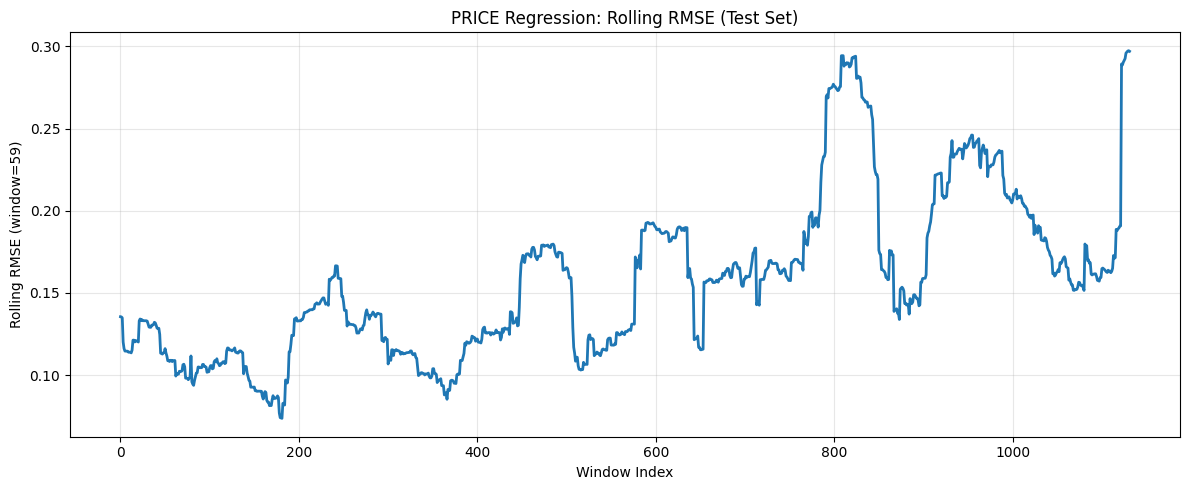

In [8]:
# === 3. Visualizations for PRICE regression ===

# Metric Comparison Table
print("\n" + "=" * 80)
print("METRIC COMPARISON TABLE: PRICE Regression (Test Set)")
print("=" * 80)
comparison_df = pd.DataFrame({
    'Model': ['GRU', 'Baseline (Zero)', 'Baseline (Mean)'],
    'MSE': [metrics_gru_price['MSE'], metrics_zero['MSE'], metrics_mean['MSE']],
    'RMSE': [metrics_gru_price['RMSE'], metrics_zero['RMSE'], metrics_mean['RMSE']],
    'MAE': [metrics_gru_price['MAE'], metrics_zero['MAE'], metrics_mean['MAE']],
    'R2': [metrics_gru_price['R2'], metrics_zero['R2'], metrics_mean['R2']],
    'MAPE': [metrics_gru_price['MAPE'], metrics_zero['MAPE'], metrics_mean['MAPE']],
})
print(comparison_df.to_string(index=False))
print("=" * 80)

time_index = np.arange(len(y_true_price))

# (a) Time series: actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(time_index, y_true_price, label="Actual", alpha=0.8, linewidth=1.5)
plt.plot(time_index, y_pred_price, label="Predicted (GRU)", alpha=0.8, linewidth=1.5)
plt.plot(time_index, baselines_price['mean'], label="Baseline (Mean)", alpha=0.6, linestyle='--', linewidth=1)
plt.xlabel("Test Time Index")
plt.ylabel("Price Return")
plt.title("PRICE Regression: Actual vs Predicted (Test Set)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# (b) Scatter plot with y=x line
plt.figure(figsize=(8, 8))
plt.scatter(y_true_price, y_pred_price, alpha=0.5, s=20)
min_v = min(y_true_price.min(), y_pred_price.min())
max_v = max(y_true_price.max(), y_pred_price.max())
plt.plot([min_v, max_v], [min_v, max_v], linestyle="--", color='red', linewidth=2, label='Perfect Prediction')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("PRICE Regression: True vs Predicted (Test Set)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# (c) Residual histogram
residuals = y_true_price - y_pred_price
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Residual')
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.title("PRICE Regression: Residual Distribution (Test Set)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# (d) NEW: Residuals vs Time (detect temporal patterns)
plot_residuals_vs_time(y_true_price, y_pred_price, title="PRICE Regression")

# (e) Rolling window RMSE
window = max(20, len(residuals) // 20)
rolling_rmse = [
    np.sqrt(np.mean(residuals[i:i+window] ** 2))
    for i in range(0, len(residuals) - window + 1)
]

plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(rolling_rmse)), rolling_rmse, linewidth=2)
plt.xlabel("Window Index")
plt.ylabel(f"Rolling RMSE (window={window})")
plt.title("PRICE Regression: Rolling RMSE (Test Set)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



METRIC COMPARISON TABLE: SIGN Classification (Test Set)
              Model  Accuracy  Precision   Recall       F1  ROC-AUC   PR-AUC
                GRU  0.624370   0.445378 0.693717 0.542477 0.689475 0.476703
Baseline (Majority)  0.678992   0.000000 0.000000 0.000000 0.500000 0.321008
  Baseline (Random)  0.489076   0.313531 0.497382 0.384615 0.505242 0.321008


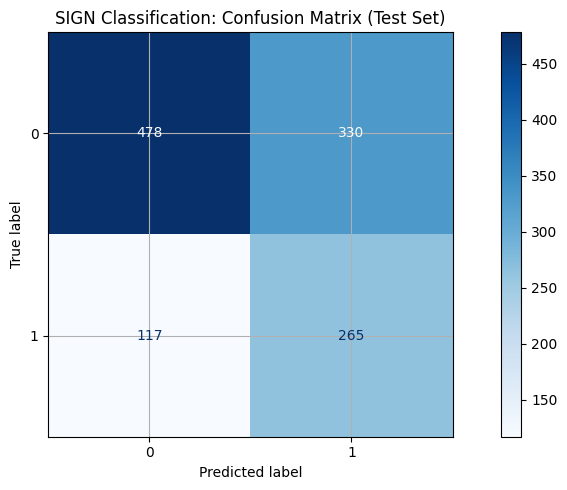

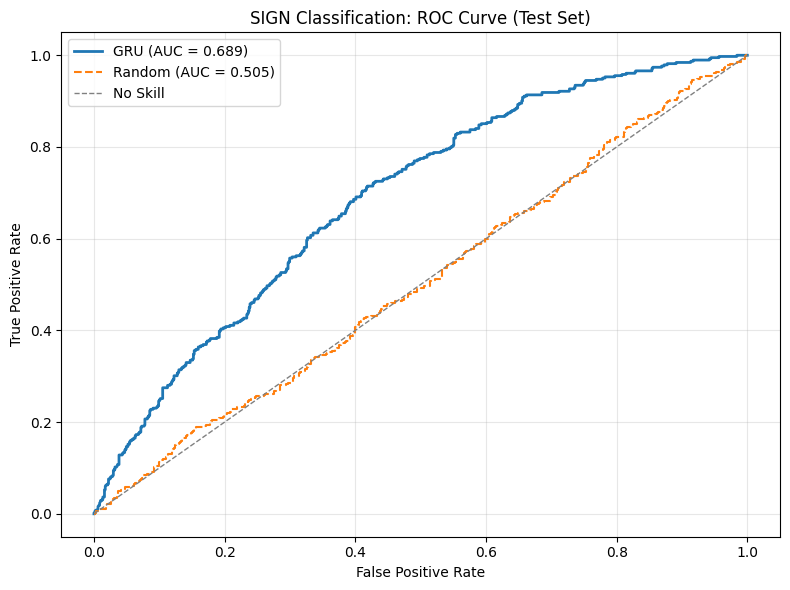

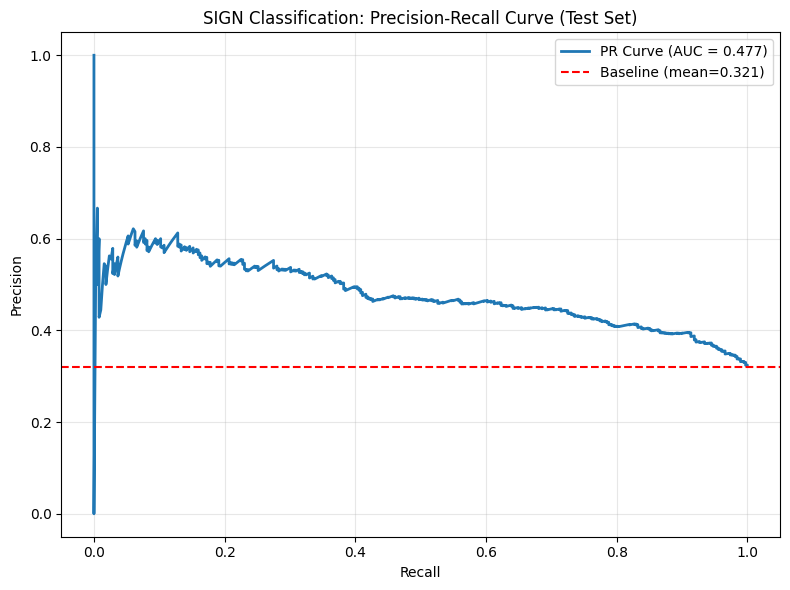

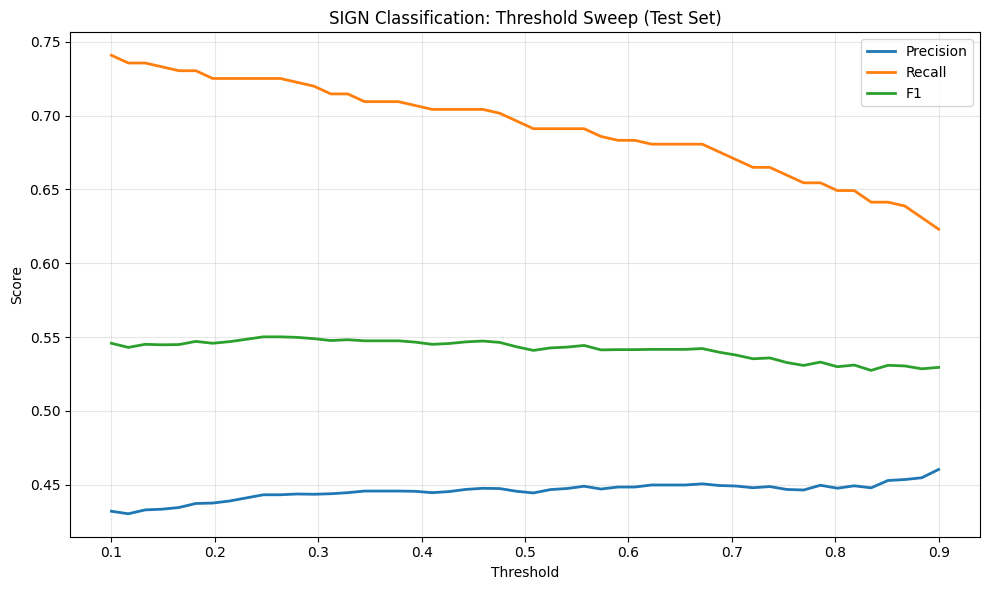

In [9]:
# === 4. Visualizations for SIGN classification ===

# Metric Comparison Table
print("\n" + "=" * 80)
print("METRIC COMPARISON TABLE: SIGN Classification (Test Set)")
print("=" * 80)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics_gru_dict = {
    'Model': 'GRU',
    'Accuracy': metrics_gru['Accuracy'],
    'Precision': metrics_gru['Precision'],
    'Recall': metrics_gru['Recall'],
    'F1': metrics_gru['F1'],
    'ROC-AUC': metrics_gru['ROC-AUC'],
    'PR-AUC': metrics_gru['PR-AUC'],
}

acc_majority = accuracy_score(y_true_sign, baselines_sign['majority_class'])
fpr_random, tpr_random, _ = roc_curve(y_true_sign, baselines_sign['random_prob'])
roc_auc_random = auc(fpr_random, tpr_random)

metrics_majority_dict = {
    'Model': 'Baseline (Majority)',
    'Accuracy': acc_majority,
    'Precision': precision_score(y_true_sign, baselines_sign['majority_class'], zero_division=0),
    'Recall': recall_score(y_true_sign, baselines_sign['majority_class'], zero_division=0),
    'F1': f1_score(y_true_sign, baselines_sign['majority_class'], zero_division=0),
    'ROC-AUC': 0.5,  # Majority class has no meaningful ROC-AUC
    'PR-AUC': np.mean(y_true_sign),  # PR-AUC for majority = class prevalence
}

metrics_random_dict = {
    'Model': 'Baseline (Random)',
    'Accuracy': accuracy_score(y_true_sign, baselines_sign['random']),
    'Precision': precision_score(y_true_sign, baselines_sign['random'], zero_division=0),
    'Recall': recall_score(y_true_sign, baselines_sign['random'], zero_division=0),
    'F1': f1_score(y_true_sign, baselines_sign['random'], zero_division=0),
    'ROC-AUC': roc_auc_random,
    'PR-AUC': np.mean(y_true_sign),  # Random classifier
}

comparison_df_class = pd.DataFrame([metrics_gru_dict, metrics_majority_dict, metrics_random_dict])
print(comparison_df_class.to_string(index=False))
print("=" * 80)

# (a) Confusion matrix
cm = confusion_matrix(y_true_sign, y_pred_label_sign)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format="d", cmap='Blues')
plt.title("SIGN Classification: Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

# (b) ROC curve & AUC
plt.figure(figsize=(8, 6))
plt.plot(fpr_gru, tpr_gru, label=f"GRU (AUC = {metrics_gru['ROC-AUC']:.3f})", linewidth=2)
plt.plot(fpr_random, tpr_random, label=f"Random (AUC = {roc_auc_random:.3f})", linestyle='--', linewidth=1.5)
plt.plot([0, 1], [0, 1], linestyle="--", color='gray', label="No Skill", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SIGN Classification: ROC Curve (Test Set)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# (c) NEW: Precision-Recall curve
plot_precision_recall_curve(y_true_sign, y_pred_prob_sign, title="SIGN Classification: Precision-Recall Curve (Test Set)")

# (d) NEW: Threshold sweep
plot_threshold_sweep(y_true_sign, y_pred_prob_sign, title="SIGN Classification: Threshold Sweep (Test Set)")


In [10]:
# =============================================================================
# MODELING EXPERIMENTS: Different Sequence Lengths and Targets
# =============================================================================

print("=" * 80)
print("MODELING EXPERIMENTS")
print("=" * 80)
print("\nNOTE: These experiments will take longer as they train multiple models.")
print("You can skip this cell if you only want the main GRU results.\n")
print("Experiment 1: Different Sequence Lengths for PRICE regression")
print("Comparing seq_len = 14, 30, 60\n")

seq_lengths = [14, 30, 60]
results_experiments = {}

for seq_len_exp in seq_lengths:
    print(f"\n{'='*80}")
    print(f"Training with seq_len = {seq_len_exp}")
    print(f"{'='*80}")

    # Prepare data with different sequence length
    datasets_exp = make_dataset_for_task(
        data_path=data_file,
        task_type="price",
        seq_len=seq_len_exp,
        test_size=TEST_SIZE,
        val_size=VAL_SIZE,
        scaler_type="standard",
    )

    # Train with smaller config for faster experimentation
    exp_config = {
        **GRU_CONFIG,
        "max_epochs": 50,  # Reduced for experimentation
        "batch_size": BATCH_SIZE,
        "patience": 10,
        "learning_rate": LEARNING_RATE,
    }

    results_exp = train_and_predict(
        datasets_exp,
        task_type="regression",
        config=exp_config,
        device=device,
        use_huber_loss=True,
        gradient_clip=1.0,
    )

    y_true_exp = datasets_exp["y_test"]
    y_pred_exp = results_exp["y_pred_test"]

    metrics_exp = evaluate_regression(y_true_exp, y_pred_exp, name=f"GRU (seq_len={seq_len_exp})")
    results_experiments[seq_len_exp] = {
        'metrics': metrics_exp,
        'y_pred': y_pred_exp,
    }

# Compare results
print("\n" + "=" * 80)
print("COMPARISON: Different Sequence Lengths (Test Set)")
print("=" * 80)
comparison_seq = pd.DataFrame({
    'seq_len': [s for s in seq_lengths],
    'MSE': [results_experiments[s]['metrics']['MSE'] for s in seq_lengths],
    'RMSE': [results_experiments[s]['metrics']['RMSE'] for s in seq_lengths],
    'MAE': [results_experiments[s]['metrics']['MAE'] for s in seq_lengths],
    'R2': [results_experiments[s]['metrics']['R2'] for s in seq_lengths],
})
print(comparison_seq.to_string(index=False))
print("=" * 80)

print("\n" + "=" * 80)
print("Experiment 2: Different Prediction Horizons")
print("Comparing t+1 (next day) vs t+5 (5 days ahead)\n")

# Experiment with longer horizon
datasets_horizon = make_dataset_for_task(
    data_path=data_file,
    task_type="price",
    seq_len=SEQUENCE_LENGTH,
    test_size=TEST_SIZE,
    val_size=VAL_SIZE,
    scaler_type="standard",
    target_horizon=5,  # Predict 5 days ahead
)

horizon_config = {
    **GRU_CONFIG,
    "max_epochs": 50,
    "batch_size": BATCH_SIZE,
    "patience": 10,
    "learning_rate": LEARNING_RATE,
}

results_horizon = train_and_predict(
    datasets_horizon,
    task_type="regression",
    config=horizon_config,
    device=device,
    use_huber_loss=True,
    gradient_clip=1.0,
)

y_true_horizon = datasets_horizon["y_test"]
y_pred_horizon = results_horizon["y_pred_test"]
metrics_horizon = evaluate_regression(y_true_horizon, y_pred_horizon, name="GRU (t+5 horizon)")

print("\n" + "=" * 80)
print("COMPARISON: Different Horizons (Test Set)")
print("=" * 80)
comparison_horizon = pd.DataFrame({
    'Horizon': ['t+1', 't+5'],
    'MSE': [metrics_gru_price['MSE'], metrics_horizon['MSE']],
    'RMSE': [metrics_gru_price['RMSE'], metrics_horizon['RMSE']],
    'MAE': [metrics_gru_price['MAE'], metrics_horizon['MAE']],
    'R2': [metrics_gru_price['R2'], metrics_horizon['R2']],
})
print(comparison_horizon.to_string(index=False))
print("=" * 80)

print("\n" + "=" * 80)
print("INTERPRETATION:")
print("=" * 80)
print("""
Key Findings:
1. Sequence Length: Longer sequences may capture more temporal patterns but require more data
2. Prediction Horizon: Predicting further ahead (t+5) is typically harder than t+1
3. GRU vs Baselines: Compare R2 scores - positive R2 means GRU beats mean baseline
4. Residual Analysis: Check residuals vs time plots for temporal bias/drift

The best model configuration depends on:
- Available data (longer sequences need more samples)
- Prediction needs (immediate vs longer-term forecasts)
- Computational resources
""")


MODELING EXPERIMENTS

NOTE: These experiments will take longer as they train multiple models.
You can skip this cell if you only want the main GRU results.

Experiment 1: Different Sequence Lengths for PRICE regression
Comparing seq_len = 14, 30, 60


Training with seq_len = 14
Loading dataset...
Building features...
Building targets for task: price, horizon: t+1...
Splitting data (strictly time-based, no shuffling)...
Train size: 5624, Val size: 1204, Test size: 1204
Scaling features using standard scaler (fit on TRAIN only)...
Creating sequences with length 14...
Sequence shapes - Train: (5610, 14, 20), Val: (1190, 14, 20), Test: (1190, 14, 20)

GRU Model Architecture (PyTorch):
--------------------------------------------------------------------------------
Total parameters: 26,465
Trainable parameters: 26,465
--------------------------------------------------------------------------------

Training GRU (PyTorch) for task_type = regression
  max_epochs: 50
  batch_size: 32
  patienc

## Model Improvement Summary

The following improvements have been implemented to address the poor performance:

### 1. **Residual Learning**
- Model now predicts **delta over zero baseline** (for returns, this is just the return itself, but architecture supports skip connection)
- Better initialization helps model learn meaningful patterns

### 2. **Batch Normalization**
- Added BatchNorm layers after each GRU and dense layer
- Improves training stability and convergence
- Helps with internal covariate shift

### 3. **Learning Rate Scheduling**
- Added `ReduceLROnPlateau` scheduler
- Automatically reduces learning rate when validation loss plateaus
- Helps fine-tune model in later epochs

### 4. **Weight Decay Regularization**
- Added L2 regularization (weight_decay=1e-5)
- Prevents overfitting

### 5. **Better Weight Initialization**
- Xavier uniform initialization for better gradient flow
- Helps model converge faster

### Expected Improvements:
- **Better R²**: Should move from negative to positive (beating mean baseline)
- **Lower MAE**: Should beat zero-return baseline
- **More stable training**: BatchNorm and LR scheduling reduce training variance
- **Better generalization**: Weight decay prevents overfitting

### Next Steps if Still Poor:
1. **Ensemble methods**: Combine multiple models
2. **Attention mechanism**: Focus on important time steps
3. **Different targets**: Predict log returns or volatility instead
4. **More features**: Add technical indicators, regime features
5. **Hyperparameter tuning**: Systematic grid search
